In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
from torch import nn

from nilearn.plotting import plot_glass_brain
import nibabel as nib

from sentence_transformers import SentenceTransformer

from neurovlm.data import fetch_data
from neurovlm.coords import coords_to_vectors
from neurovlm.models import NeuroAutoEncoder, TextAligner
from neurovlm.train import Trainer, which_device
device = which_device()

# Training

This notebook trains the `neurovlm` model. Sections include:

1. Load coordinates
2. Extract neuro-vectors
3. Train autoencoder
4. Train text aligner
5. Results

## 1. Load Coordinates

Data from 25k articles, fetched and processed with `pubget`.

- article id
- titles
- dois
- MNI coordinates

In [2]:
data_dir = fetch_data()
df_pubs = pd.read_parquet(f"{data_dir}/publications.parquet")
df_coords = pd.read_parquet(f"{data_dir}/coordinates.parquet")

## 2. Extract Neuro-vectors

Smooth coordinates with 9mm Gaussian kernel and extract a 28542 dimensional vector. The vector is binarized and the autoencoder will minimize binary cross entropy.

In [3]:
# Convert coordinates to MNI space vectors
neuro_vectors, df_pubs = coords_to_vectors(df_coords, df_pubs)

# Binarize for classification
neuro_vectors[neuro_vectors > 0.0] = 1.0
neuro_vectors = neuro_vectors.to("cpu")

# Save
torch.save(neuro_vectors, "neuro_vectors.pt")
df_pubs.to_csv("publications.csv")

  0%|          | 0/28393 [00:00<?, ?it/s]

In [4]:
# Skip above if previously trained
neuro_vectors = torch.load(
    "neuro_vectors.pt", weights_only=True
).to("cpu")

df_pubs = pd.read_csv("publications.csv")

## 3. Train Autoencoder

Train an autoencoder on the neuro-vectors.

1. Encoder: Neuro-vector to low-dimensional (384) latent vector / embedding space

2. Decoder: Latent vector to produces MNI space predictions.

The 384 latent dimension was chosen to match the latent dimension of the chosen text encoder.

In [5]:
# Train/test/validation split
inds = torch.arange(len(neuro_vectors))
train_inds, test_inds = train_test_split(
    inds, train_size=0.8, random_state=0
)
test_inds, val_inds = train_test_split(
    test_inds, train_size=0.5, random_state=1
)

In [6]:
# Train
trainer = Trainer(
    NeuroAutoEncoder(seed=0),
    n_epochs=100,
    batch_size=256,
    lr=1e-4,
    loss_fn=nn.BCELoss(),
    optimizer=torch.optim.AdamW,
    X_val=neuro_vectors[val_inds],
    device="auto"
)

# Fit
trainer.fit(neuro_vectors[train_inds])

# Save
trainer.save("autoencoder.pt")

# Unpack
autoencoder = trainer.model

Epoch: 99,  val loss:  0.69321 (initial) -> 0.15089 (current)

In [5]:
# Skip above if previously trained
autoencoder = torch.load(
    "autoencoder.pt", weights_only=False
).to(device)

## 4. Train Text Encoder

Use a small sentence-BERT transformer to compute latent text vectors for each publication's title. For other transformers, see the `sentence-transformers` package. The `TextAligner` model transforms latext text to latent MNI space. Then the neuro-decoder can transform the aligned latent text, to MNI space, resulting in a generative model.

In [8]:
# Encode MNI vectors
with torch.no_grad():
    latent_neuro = autoencoder.encoder(
        neuro_vectors.to(device)
    ).detach()

# Encode titles
model = SentenceTransformer("paraphrase-MiniLM-L3-v2").to(device)
with torch.no_grad():
    latent_text = model.encode(
        df_pubs["name"].tolist(), convert_to_tensor=True
    ).detach()

In [9]:
# Train
align_trainer = Trainer(
    TextAligner(seed=0),
    n_epochs=500,
    batch_size=1028,
    lr=2e-4,
    loss_fn=nn.MSELoss(),
    optimizer=torch.optim.AdamW,
    X_val=latent_text[val_inds],
    y_val=latent_neuro[val_inds],
    device="auto"
)

# Fit
align_trainer.fit(
    latent_text[train_inds],
    latent_neuro[train_inds]
)

# Save
align_trainer.save("aligner.pt")

# Unpack
aligner = align_trainer.model

Epoch: 499,  val loss:  73.314 (initial) -> 25.412 (current)

In [7]:
# Skip above if previously trained
aligner = torch.load(
    "aligner.pt", weights_only=False
).to(device)

## 5. Results

Lastly, test predictions are made on "vision" and "motor" and plotted. These results correspond to the visual and motor cortices, respectively. The next tutorial explores vector projection for when a query is out-of-sample or uncommon in neuroscience research, yet has semantic mappings to other neuroscientific terms.

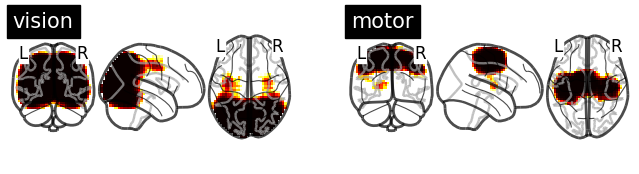

In [10]:
# Load mask
mask_arrays = np.load(f"{data_dir}/mask.npz", allow_pickle=True)
mask = mask_arrays["mask"]
affine = mask_arrays["affine"]

# Test queries
queries = ["vision", "motor"]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 2))
for i, query in enumerate(queries):
    # Encode text
    encoded_text = model.encode(
        query, convert_to_tensor=True, device="cpu"
    )
    # Align text
    aligned_text = aligner.to("cpu")(encoded_text)
    
    # Decode brain
    neuro_pred = autoencoder.to("cpu").decoder(
        aligned_text
    ).detach().numpy()

    # Plot
    pred = np.zeros(mask.shape)
    pred[mask] = neuro_pred
    img = nib.Nifti1Image(pred, affine)
    plot_glass_brain(img, threshold=.5, vmin=.5, vmax=1,
                     title=query, axes=axes[i]);